In [19]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_video
from torchvision import transforms
import matplotlib.pyplot as plt
from IPython.display import clear_output
from model_package import VideoDataset, resize_tensor, create_paths_labels, load_model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Validation Path

In [20]:
trained_model_path = '/Users/melvinkisam/Documents/python-workspace/notts-dissertation/badminton-rally-classification/model-training/trained_models/trained_model_3.pth'

# val_file = [
#     "/Users/melvinkisam/Documents/python-workspace/notts-dissertation/badminton-rally-classification/dataset-creation/dataset/training-input/i3D/match_8-sb.txt",
#     "/Users/melvinkisam/Documents/python-workspace/notts-dissertation/badminton-rally-classification/dataset-creation/dataset/training-input/i3D/match_9-sb.txt",
# ]

val_file = [
    "/Users/melvinkisam/Documents/python-workspace/notts-dissertation/badminton-rally-classification/dataset-creation/dataset/training-input/raw/match_8-sb.txt",
    "/Users/melvinkisam/Documents/python-workspace/notts-dissertation/badminton-rally-classification/dataset-creation/dataset/training-input/raw/match_9-sb.txt",
]

In [21]:
valPaths, valLabels = create_paths_labels(val_file)

transform = transforms.Compose([
    transforms.Lambda(lambda x: resize_tensor(x, size=(224, 224)))
])

val_dataset = VideoDataset(valPaths, valLabels, transform)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [22]:
from collections import Counter

label_counts = Counter(valLabels)

print("Validation class distribution (no of clips):")
for label, count in sorted(label_counts.items()):
    print(f"Class {label}: {count} samples")

Validation class distribution (no of clips):
Class 0: 171 samples
Class 1: 204 samples
Class 2: 28 samples
Class 3: 10 samples
Class 4: 17 samples


In [23]:
checkpoint = torch.load(trained_model_path, map_location=device)

model = load_model()  # Must match architecture used before
model.load_state_dict(checkpoint['model_state_dict'])

optimizer = optim.Adam(model.parameters(), lr=1e-4)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

start_epoch = checkpoint['epoch'] + 1  # Resume from next epoch
loss = checkpoint['loss']

Inference: 100%|██████████| 108/108 [04:10<00:00,  2.32s/it]


Inference Accuracy: 87.91%


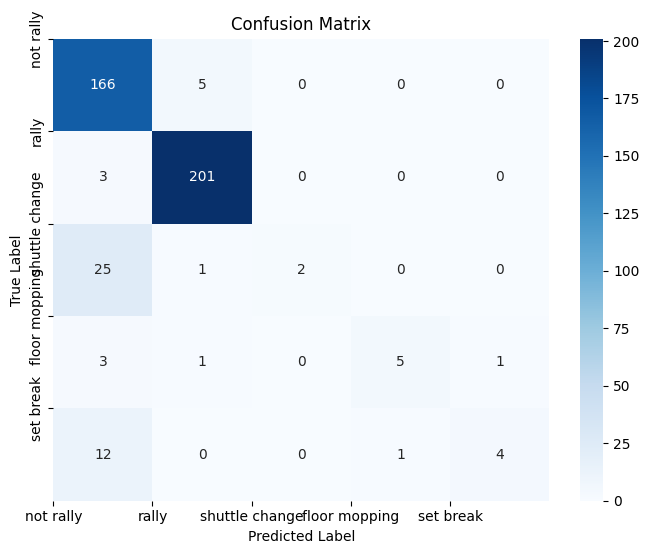

In [24]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# Inference
model.eval()
final_preds = []
final_labels = []

with torch.no_grad():
    for videos, labels in tqdm(val_loader, desc="Inference"):
        videos, labels = videos.to(device), labels.to(device)
        outputs = model(videos)

        preds = torch.argmax(outputs, dim=1)

        final_preds.extend(preds.cpu().numpy())
        final_labels.extend(labels.cpu().numpy())

# Compute accuracy
infer_accuracy = accuracy_score(final_labels, final_preds)
print(f"\nInference Accuracy: {infer_accuracy * 100:.2f}%")

class_names = ['not rally', 'rally', 'shuttle change', 'floor mopping', 'set break']

# Confusion matrix
cm = confusion_matrix(final_labels, final_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(ticks=range(len(class_names)), labels=class_names)
plt.yticks(ticks=range(len(class_names)), labels=class_names)
plt.show()